In [10]:
import sys
sys.path.append("..")
from geomatry.opt.scipy_optimizer import MultiSystemOptimizer
from geomatry.opt_Energy_approximated.optimizer import MultipleSystemOptimizer as MultiSystemOptimizer_Energy
from geomatry.opt.loss import rmsd_loss
from geomatry.ff.graph import get_given_graph_builder
from geomatry.ff.springs import SpringFF, _random_spring_systems, _random_spring_ff_param
import torch
import copy

systemN = 40
N = 20
N_pairs = 100
max_Za = 3
Ras, Zas, idx_is, idx_js = _random_spring_systems(systemN, N, N_pairs, max_Za, start_Za=1)
k, r0 = _random_spring_ff_param(max_Za, r0_max=5, k_max=5)
ff = SpringFF(max_Za)
ff.reset_parameters(k, r0)

fixed_atom_indices = [0, 1, 2]
graph_builders = [get_given_graph_builder(idx_i, idx_j) for idx_i, idx_j in zip(idx_is, idx_js)]

# start implicit optimization
params_star = ff.state_dict()
params_goal = copy.deepcopy(params_star)
print("params_star", params_star)
optimizer = MultiSystemOptimizer(
    Ras, Zas, graph_builders, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)


optimizer_Energy = MultiSystemOptimizer_Energy(
    Ras, Zas, graph_builders, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)

k_perturbed = torch.clamp(k.clone() + 0.3*torch.randn_like(k), min=0)
r0_perturbed = torch.clamp(r0.clone() + 0.3*torch.randn_like(r0), min=0)
ff.reset_parameters(k_perturbed, r0_perturbed)
params_0 = ff.state_dict()
params_0_old = copy.deepcopy(params_0)
print("params_0", params_0)
new_params_0=optimizer.optimize_Adam(3000,params_0)
print("params_optimized",new_params_0)

params_star OrderedDict([('k', tensor([[2.0904, 3.7634, 4.1067, 2.8150],
        [3.7634, 0.4514, 1.6391, 3.7594],
        [4.1067, 1.6391, 1.3337, 2.6949],
        [2.8150, 3.7594, 2.6949, 4.9597]], dtype=torch.float64)), ('r0', tensor([[0.7585, 1.5633, 1.2447, 0.8921],
        [1.5633, 1.8191, 1.9790, 2.2577],
        [1.2447, 1.9790, 2.5993, 2.4064],
        [0.8921, 2.2577, 2.4064, 4.4867]], dtype=torch.float64))])
params_0 OrderedDict([('k', tensor([[2.5079, 3.6191, 4.2173, 3.0326],
        [3.6191, 0.0848, 1.3641, 3.6731],
        [4.2173, 1.3641, 1.7660, 3.0787],
        [3.0326, 3.6731, 3.0787, 4.9750]], dtype=torch.float64)), ('r0', tensor([[0.4691, 1.5140, 1.4498, 1.0712],
        [1.5140, 2.1505, 1.8456, 1.9787],
        [1.4498, 1.8456, 2.8785, 2.4851],
        [1.0712, 1.9787, 2.4851, 4.4775]], dtype=torch.float64))])


/Users/soonhyun/Desktop/GeometryOptimization/Landscape_Fork/GeoMatry_LandscapeBased/GeoMatry_LandscapeBased/demo/../geomatry/opt/scipy_optimizer.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = nn.Parameter(torch.tensor(initial_params_flat, dtype=torch.float32))


Step 100/3000, Loss: 3.639621
Step 200/3000, Loss: 1.450742
Step 300/3000, Loss: 0.973548
Step 400/3000, Loss: 1.410605
Step 500/3000, Loss: 0.481943
Step 600/3000, Loss: 1.262040
Step 700/3000, Loss: 0.335447
Step 800/3000, Loss: 0.155809
Step 900/3000, Loss: 0.122572
Step 1000/3000, Loss: 0.087198
Step 1100/3000, Loss: 0.010938
Step 1145/3000, Loss: 0.000500
params_optimized OrderedDict([('k', tensor([[2.5079, 3.6191, 4.2173, 3.0326],
        [3.6191, 0.4721, 1.7147, 3.9325],
        [4.2173, 1.7147, 1.3946, 2.8181],
        [3.0326, 3.9325, 2.8181, 5.1899]], dtype=torch.float64,
       grad_fn=<ViewBackward0>)), ('r0', tensor([[0.4691, 1.5140, 1.4498, 1.0712],
        [1.5140, 1.8191, 1.9789, 2.2577],
        [1.4498, 1.9789, 2.5992, 2.4063],
        [1.0712, 2.2577, 2.4063, 4.4867]], dtype=torch.float64,
       grad_fn=<ViewBackward0>))])


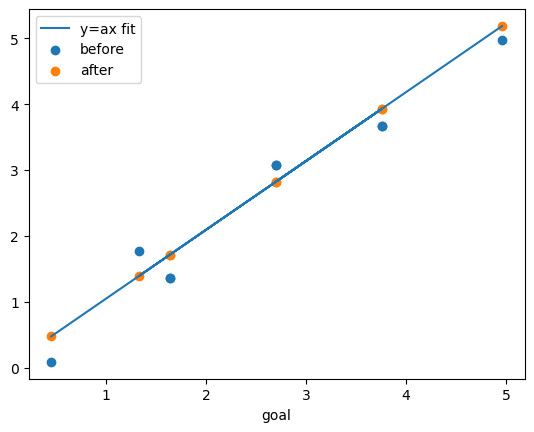

In [11]:
#Compare
import matplotlib.pyplot as plt

new_params_0['k']=(new_params_0['k']+new_params_0['k'].T)/2
params_goal['k']=(params_goal['k']+params_goal['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

for key in params_goal.keys():
    params_goal[key]=params_goal[key].detach()

for key in new_params_0.keys():
    new_params_0[key]=new_params_0[key].detach()


for key in new_params_0.keys():
    new_params_0[key]=new_params_0[key].detach()

a=torch.sum(new_params_0['k'][1:,1:].reshape(-1))/torch.sum(params_goal['k'][1:,1:].reshape(-1))
plt.plot(params_goal['k'][1:,1:].reshape(-1),a*params_goal['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_goal['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_goal['k'][1:,1:].reshape(-1),new_params_0['k'][1:,1:].reshape(-1),label='after')
plt.xlabel('goal')
plt.legend()
plt.show()

params_0 OrderedDict([('k', tensor([[2.5079, 3.6191, 4.2173, 3.0326],
        [3.6191, 0.0848, 1.3641, 3.6731],
        [4.2173, 1.3641, 1.7660, 3.0787],
        [3.0326, 3.6731, 3.0787, 4.9750]], dtype=torch.float64)), ('r0', tensor([[0.4691, 1.5140, 1.4498, 1.0712],
        [1.5140, 2.1505, 1.8456, 1.9787],
        [1.4498, 1.8456, 2.8785, 2.4851],
        [1.0712, 1.9787, 2.4851, 4.4775]], dtype=torch.float64))])


  0%|          | 0/4001 [00:00<?, ?it/s]

0 curvature tensor(14.2940, dtype=torch.float64, grad_fn=<DivBackward0>) 175.25162224834287 distance 0.5295010471481423 loss 1841.4297144326224
trueloss 1841.4297144326224
loss 1841.4297144326224
tensor([-0.6975, -0.6609, -0.4185, -0.6445, -0.5482, -0.5160],
       dtype=torch.float64, grad_fn=<SubBackward0>)


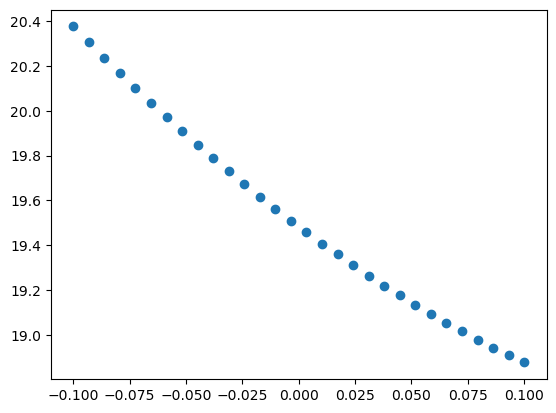

100%|█████████▉| 3995/4001 [01:22<00:00, 50.02it/s]

4000 curvature tensor(10.8051, dtype=torch.float64, grad_fn=<DivBackward0>) 3.158403491668271e-05 distance 0.0002249441306693077 loss 0.024892100463039975
trueloss 0.024892100463039975
loss 0.024892100463039975
tensor([0.0939, 0.1484, 0.0412, 0.0527, 0.0721, 0.0504], dtype=torch.float64,
       grad_fn=<SubBackward0>)


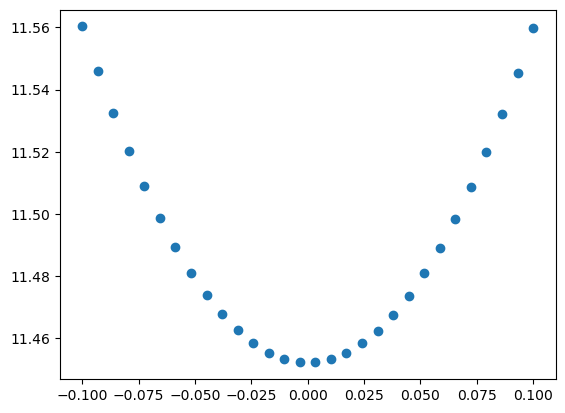

100%|██████████| 4001/4001 [01:22<00:00, 48.25it/s]


In [12]:
def energyAndRsquare(k_perturbed, r0_perturbed, optimizer):
    ff.reset_parameters(k_perturbed, r0_perturbed)
    params_0 = ff.state_dict()
    print("params_0", params_0)
    for i in range(1):
        params_0=optimizer.optimize(params_0, 4001, 4000, 0.02, 6, 2)
    return params_0
new_params_0_Energy=energyAndRsquare(k_perturbed, r0_perturbed, optimizer_Energy)


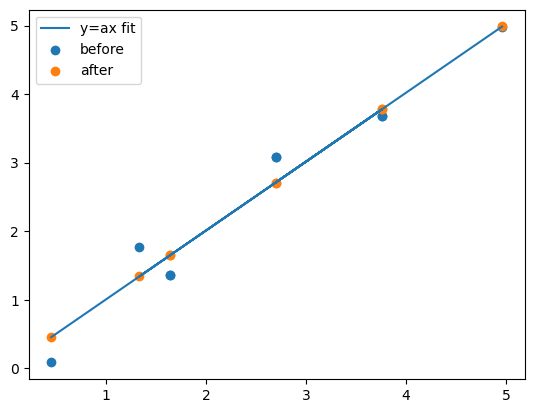

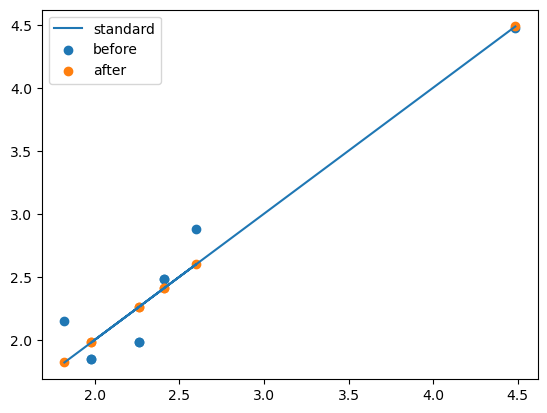

In [15]:
#Confirm
import matplotlib.pyplot as plt

new_params_0_Energy['k']=(new_params_0_Energy['k']+new_params_0_Energy['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0_Energy['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0_Energy['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),params_0_old['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),new_params_0_Energy['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()